# This notebook shows how to implement K-Nearest Neighbours from scratch

In [1]:
%cd 'C:\Users\Rolex James\Documents\MOOCs\ML Univ of Washington\Regression\Resources'

C:\Users\Rolex James\Documents\MOOCs\ML Univ of Washington\Regression\Resources


In [2]:
#import needed libraries
import numpy as np
import graphlab as gl #data is in SFrame format

### For this demonstration, I am using a subet of King County house sales dataset

In [3]:
#Load the dataset
sales = gl.SFrame('kc_house_data_small.gl/')

This non-commercial license of GraphLab Create is assigned to tolurotimibabalola@gmail.com and will expire on December 29, 2016. For commercial licensing options, visit https://dato.com/buy/.


2016-05-28 08:58:01,848 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: C:\Users\ROLEXJ~1\AppData\Local\Temp\graphlab_server_1464422274.log.0


### Exploring the dataset

In [4]:
sales.head(5)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
7129300520,2014-10-13 00:00:00+00:00,221900,3.0,1.0,1180.0,5650,1.0,0
6414100192,2014-12-09 00:00:00+00:00,538000,3.0,2.25,2570.0,7242,2.0,0
5631500400,2015-02-25 00:00:00+00:00,180000,2.0,1.0,770.0,10000,1.0,0
2487200875,2014-12-09 00:00:00+00:00,604000,4.0,3.0,1960.0,5000,1.0,0
1954400510,2015-02-18 00:00:00+00:00,510000,3.0,2.0,1680.0,8080,1.0,0
view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat
0,3,7,1180,0,1955,0,98178,47.51123398
0,3,7,2170,400,1951,1991,98125,47.72102274
0,3,6,770,0,1933,0,98028,47.73792661
0,5,7,1050,910,1965,0,98136,47.52082


#### Split data into training, validation and test sets

In [5]:
(train_and_validation, test) = sales.random_split(.8, seed=1)
(train, validation) = train_and_validation.random_split(.8, seed=1)

In [6]:
#Nearest neighbour requires the data into in a matrix form
#The following code achieve that
def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

### Normalizing features 

When computing distances it is crucial that we normalize our features. Otherwise, features with much larger values will exert more influence on the distance than smaller features. For example the 'sqft_living' feature (which has values in the order of thousands) will exert more influence on distance compared to the 'bedrooms' feature (which typically has values in the order of ones)

In [7]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix / norms
    return (normalized_features, norms)

In [8]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']

In [9]:
#Make numpy array of our features and the output
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In [10]:
#Normalize the training, validation and test datasets
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

## Computing distance

For this demonstration, I will use the Euclidean distance metric to measure the 'distance' between houses. Below is a function that uses the Euclidean metric to calculate the distance between two points **x** and **y**

In [11]:
def calculateDist(x,y):
    return np.sqrt(np.sum((x-y)**2))

In [12]:
#Calulate distance between tenth house in training data and first house in the test data
print calculateDist(features_test[0], features_train[9])

0.0597235937167


#### Let's see the distance of the first 10 houses in the training data to the first house in the test data

In [13]:
def get_N_Distances(features_test, features_train, n=10):
    for i in range(n):
        print "House ", i+1
        print "Distance from query house ", np.sqrt(np.sum((features_test[0]-features_train[i])**2))

In [14]:
get_N_Distances(features_test, features_train)

House  1
Distance from query house  0.060274709173
House  2
Distance from query house  0.0854688114883
House  3
Distance from query house  0.0614994643712
House  4
Distance from query house  0.0534027397882
House  5
Distance from query house  0.0584448406394
House  6
Distance from query house  0.0598792151018
House  7
Distance from query house  0.0546314049726
House  8
Distance from query house  0.0554310832416
House  9
Distance from query house  0.052383627841
House  10
Distance from query house  0.0597235937167


The 9th house is the closest among the first ten houses

## Making Predictions

We make predictions by finding the **k** closest houses in the training data to a house in the test data. The average price of the **k** closest houses in the training set is predicted to be the price of this house. For example, if **k** = 3 it means we will predict the price of a house to be the average price of the 3 closest houses to it in the training set

In [15]:
def multPredFromKNN(k, features_train, output_train, query_set):
    #List to contain the predicted price for each house in the test set
    priceList = []
    for i in xrange(query_set.shape[0]):
        #Find the distances
        myDiff = features_train[0:len(features_train)] - query_set[i]
        myDistances = np.sqrt(np.sum(myDiff**2, axis=1))
        sortDist = np.argsort(myDistances) #returns sorted indices for distances array
        #Select the k closest houses
        sortInd = sortDist[0:k]
        #Predict price to be mean of k closest houses
        pred = np.mean(output_train[sortInd])
        priceList.append(pred)
    return np.array(priceList)

### Let's make predictions for the first 10 houses in the test data, using **k** = 5

In [16]:
knn_predictions = multPredFromKNN(5, features_train, output_train, features_test[0:10])

In [17]:
knn_predictions

array([ 878000.,  418520.,  381190.,  530200.,  869700.,  697590.,
        332764.,  530000.,  493000.,  449780.])

Since we are making numerical predictions, let's get the RSS for prediction using **k** = 5

In [18]:
def get_RSS(predictions, output):
    resid = output - predictions
    temp = resid**2
    RSS = sum(temp)
    return RSS

In [19]:
knn_predictions = multPredFromKNN(5, features_train, output_train, features_test)

In [21]:
print get_RSS(knn_predictions, output_test)

1.32270467767e+14


## What is the best value of k?

In order to find the optimal value of **k**, we try different values of **k** ranging from 1 to 15 on the validation data.

In [22]:
#Find the best the value of k in a range of values
def find_best_RSS(query_set, k = 16):
    all_RSS = [] #list to store RSS values for each k
    for k_val in xrange(1, k):
        myPred = multPredFromKNN(k_val, features_train, output_train, query_set)
        tempRSS = get_RSS(myPred, output_valid)
        all_RSS.append(tempRSS)
    return np.array(all_RSS)

In [23]:
RSS_list = find_best_RSS(features_valid)

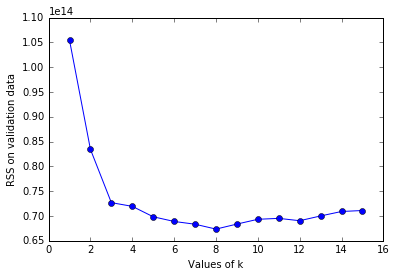

In [24]:
#Make plot of RSS for each value of k
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, RSS_list,'bo-')
plt.xlabel('Values of k')
plt.ylabel('RSS on validation data')

From the plot we can see that the best **k** = 8

Let's use **k** = 8 to make predictions on the test data

In [25]:
knn_8_preds = multPredFromKNN(8, features_train, output_train, features_test)

In [26]:
#Let's see the first 10 predicted prices for the first ten houses in the test set
knn_8_preds[0:10]

array([ 864750.   ,  462700.   ,  394493.75 ,  470375.   ,  771062.5  ,
        662118.75 ,  343290.   ,  508750.875,  463000.   ,  482856.25 ])

In [27]:
#Let's look at the actual prices
output_test[0:10]

array([650000, 485000, 438000, 535000, 785000, 975000, 287000, 355000,
       305000, 518500], dtype=int64)

Not bad :)

In [28]:
#Get RSS for k = 8
print get_RSS(knn_8_preds, output_test)

1.33118823552e+14
